# 메시지 삭제하는 방법

In [1]:
 %pip install -Uq langgraph langsmith langchain_groq langchain_tavily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 9.4 MB/s eta 0:00:00


In [2]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "09-LangGraph-DeleteMessages"

In [10]:
from typing import TypedDict, Annotated
from langchain_core.messages import ChatMessage
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list[ChatMessage], add_messages]


search = TavilySearch(max_results=3)
tools = [search]

llm = ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools = llm.bind_tools(tools)

tool_node = ToolNode(tools)

memory = MemorySaver()

def chatbot(state: State):
  answer = llm_with_tools.invoke(state["messages"])
  return {"messages": [answer]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(checkpointer=memory)

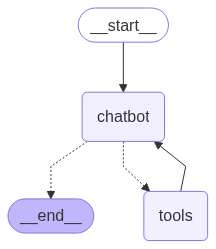

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})

query = "안녕하세요. 반가워요."
for event in graph.stream({"messages": [("user", query)]}, config=config, stream_mode="values"):
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요. 반가워요.
================================== Ai Message ==================================

안녕하세요! 반갑습니다. 무엇을 도와드릴까요?


In [13]:
query = "방금 제가 뭐라고 했어요?"
for event in graph.stream({"messages": [("user", query)]}, config=config, stream_mode="values"):
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

방금 제가 뭐라고 했어요?
================================== Ai Message ==================================

방금 “안녕하세요. 반가워요.” 라고 말씀하셨어요.


In [14]:
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='안녕하세요. 반가워요.', additional_kwargs={}, response_metadata={}, id='4ed7b6a1-62e6-4c86-bbd1-e3d8ce604020'),
 AIMessage(content='안녕하세요! 반갑습니다. 무엇을 도와드릴까요?', additional_kwargs={'reasoning_content': 'User says: "안녕하세요. 반가워요." (Hello, nice to meet you.) We should respond in Korean. Probably friendly greeting. No request. Just greet back.'}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 1364, 'total_tokens': 1426, 'completion_time': 0.054870055, 'prompt_time': 0.099165972, 'queue_time': 0.002823398, 'total_time': 0.154036027}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_975647f521', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e7a80b3-f744-4a63-900f-fa27060bcd19-0', usage_metadata={'input_tokens': 1364, 'output_tokens': 62, 'total_tokens': 1426}),
 HumanMessage(content='방금 제가 뭐라고 했어요?', additional_kwargs={}, response_metadata={}, id='0ac2cf97-272b-4676-a012-e27ae542d32c'),
 AIMessage(con

In [15]:
from langchain_core.messages import RemoveMessage

graph.update_state(config, values={"messages": [RemoveMessage(id="0ac2cf97-272b-4676-a012-e27ae542d32c")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09955a-6b4a-6b36-8005-65d06542a61a'}}

In [16]:
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='안녕하세요. 반가워요.', additional_kwargs={}, response_metadata={}, id='4ed7b6a1-62e6-4c86-bbd1-e3d8ce604020'),
 AIMessage(content='안녕하세요! 반갑습니다. 무엇을 도와드릴까요?', additional_kwargs={'reasoning_content': 'User says: "안녕하세요. 반가워요." (Hello, nice to meet you.) We should respond in Korean. Probably friendly greeting. No request. Just greet back.'}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 1364, 'total_tokens': 1426, 'completion_time': 0.054870055, 'prompt_time': 0.099165972, 'queue_time': 0.002823398, 'total_time': 0.154036027}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_975647f521', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e7a80b3-f744-4a63-900f-fa27060bcd19-0', usage_metadata={'input_tokens': 1364, 'output_tokens': 62, 'total_tokens': 1426}),
 AIMessage(content='방금 “안녕하세요. 반가워요.” 라고 말씀하셨어요.', additional_kwargs={'reasoning_content': 'User says: "방금 제가 뭐라고 했어요?" They want to recall wh

In [17]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END
from typing import Literal

# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: State) -> Literal["tools", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 tools 실행
    return "tools"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_node("delete_messages", delete_messages)
workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {"delete_messages": "delete_messages", "tools": "tools"}
)
workflow.add_edge("tools", "chatbot")
workflow.add_edge("delete_messages", END)

app = workflow.compile(checkpointer=memory)

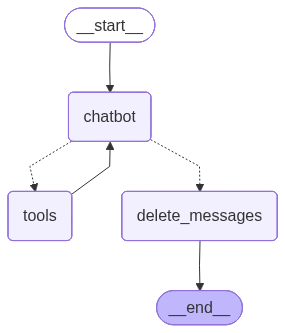

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
from typing import Literal
from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from langchain_core.messages import RemoveMessage


def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}

workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_node("delete_messages", delete_messages)
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: "delete_messages", }
)
workflow.add_edge("tools", "chatbot")
workflow.set_entry_point("chatbot")
workflow.set_finish_point("delete_messages")

app = workflow.compile(checkpointer=memory)

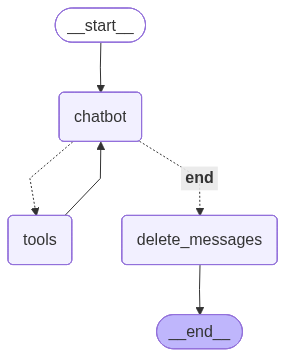

In [20]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))